# EasyVisa – Visa Approval Prediction

## Problem Statement

The U.S. faces rising demand for skilled foreign workers, leading to a surge in visa applications. In FY 2016 alone, the Department of Labor processed over 775,000 applications for 1.7 million positions. Reviewing each case manually is becoming increasingly difficult.

EasyVisa aims to develop a machine learning model that predicts whether a visa application will be approved or denied, based on applicant and employer attributes. This solution will help streamline decision-making, identify key approval factors, and recommend high-likelihood applicant profiles.

## Data Dictionary

| Feature Name              | Description                                                                 |
|---------------------------|-----------------------------------------------------------------------------|
| `case_id`                 | Unique identifier for each visa application (drop during modeling).         |
| `continent`               | Continent of the applicant (e.g., Asia, Europe, Africa).                    |
| `education_of_employee`   | Highest education level of the applicant (e.g., Bachelors, Masters, PhD).   |
| `has_job_experience`      | Whether the applicant has relevant job experience (`Y` = Yes, `N` = No).    |
| `requires_job_training`   | Whether the job position requires additional training (`Y` or `N`).         |
| `no_of_employees`         | Number of employees in the applying company.                                |
| `yr_of_estab`             | Year in which the company was established.                                  |
| `region_of_employment`    | Geographic region where the applicant will be employed.                     |
| `prevailing_wage`         | Wage offered to the applicant for the position.                             |
| `unit_of_wage`            | Wage unit (e.g., Yearly, Monthly, Weekly, Hourly).                          |
| `full_time_position`      | Whether the job is full-time (`Y`) or part-time (`N`).                      |
| `case_status`             | **Target variable**: Whether the application was **Certified** or **Denied**. |



In [1]:
# conda create --name gl python=3.11
# conda activate gl

# Install the required libraries
!pip install -U pandas numpy matplotlib seaborn scikit-learn xgboost imblearn

# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading & Initial Exploration

In [2]:
# Load dataset
df = pd.read_csv('./data/EasyVisa.csv')
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [3]:
# Basic structure and shape
print("\nDataset Shape:", df.shape)
print("\nDataset Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())
print("\nBasic Statistics:")
print(df.describe())



Dataset Shape: (25480, 12)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB

Missing Values:
case_id                  0
continent     

In [4]:
# Data types and column summaries
# Display data types of each column
print("\nData Types:")
print(df.dtypes)

# Display unique values and their counts for categorical columns
print("\nUnique Values in Categorical Columns:")
categorical_columns = ['continent', 'education_of_employee', 'has_job_experience', 
                      'requires_job_training', 'region_of_employment', 
                      'unit_of_wage', 'full_time_position', 'case_status']

for col in categorical_columns:
    print(f"\n{col}:")
    print(df[col].value_counts())
    print(f"Number of unique values: {df[col].nunique()}")



Data Types:
case_id                   object
continent                 object
education_of_employee     object
has_job_experience        object
requires_job_training     object
no_of_employees            int64
yr_of_estab                int64
region_of_employment      object
prevailing_wage          float64
unit_of_wage              object
full_time_position        object
case_status               object
dtype: object

Unique Values in Categorical Columns:

continent:
continent
Asia             16861
Europe            3732
North America     3292
South America      852
Africa             551
Oceania            192
Name: count, dtype: int64
Number of unique values: 6

education_of_employee:
education_of_employee
Bachelor's     10234
Master's        9634
High School     3420
Doctorate       2192
Name: count, dtype: int64
Number of unique values: 4

has_job_experience:
has_job_experience
Y    14802
N    10678
Name: count, dtype: int64
Number of unique values: 2

requires_job_training:
req

## Exploratory Data Analysis (EDA)

### Univariate Analysis

#### Distribution of numerical variables

In [5]:
# no_of_employees analysis, std, mean, median, mode, min, max, range, quartiles, IQR
df['no_of_employees'].describe()

count     25480.000000
mean       5667.043210
std       22877.928848
min         -26.000000
25%        1022.000000
50%        2109.000000
75%        3504.000000
max      602069.000000
Name: no_of_employees, dtype: float64

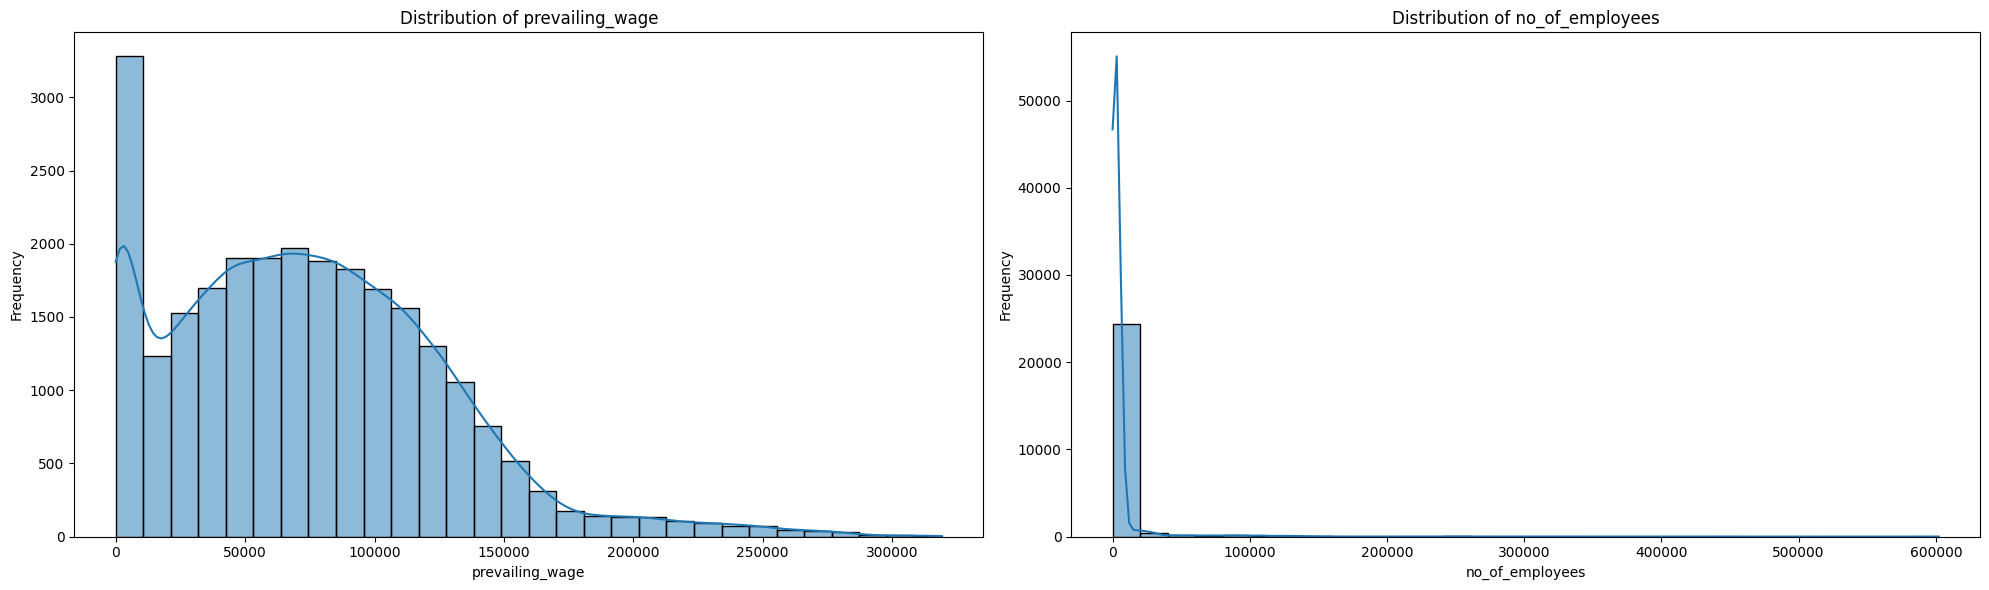

In [6]:
numerical_columns = ['prevailing_wage', 'no_of_employees']

fig, axes = plt.subplots(1, len(numerical_columns), figsize=(20, 6))
for i, col in enumerate(numerical_columns):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()


#### Count plots for categorical variables

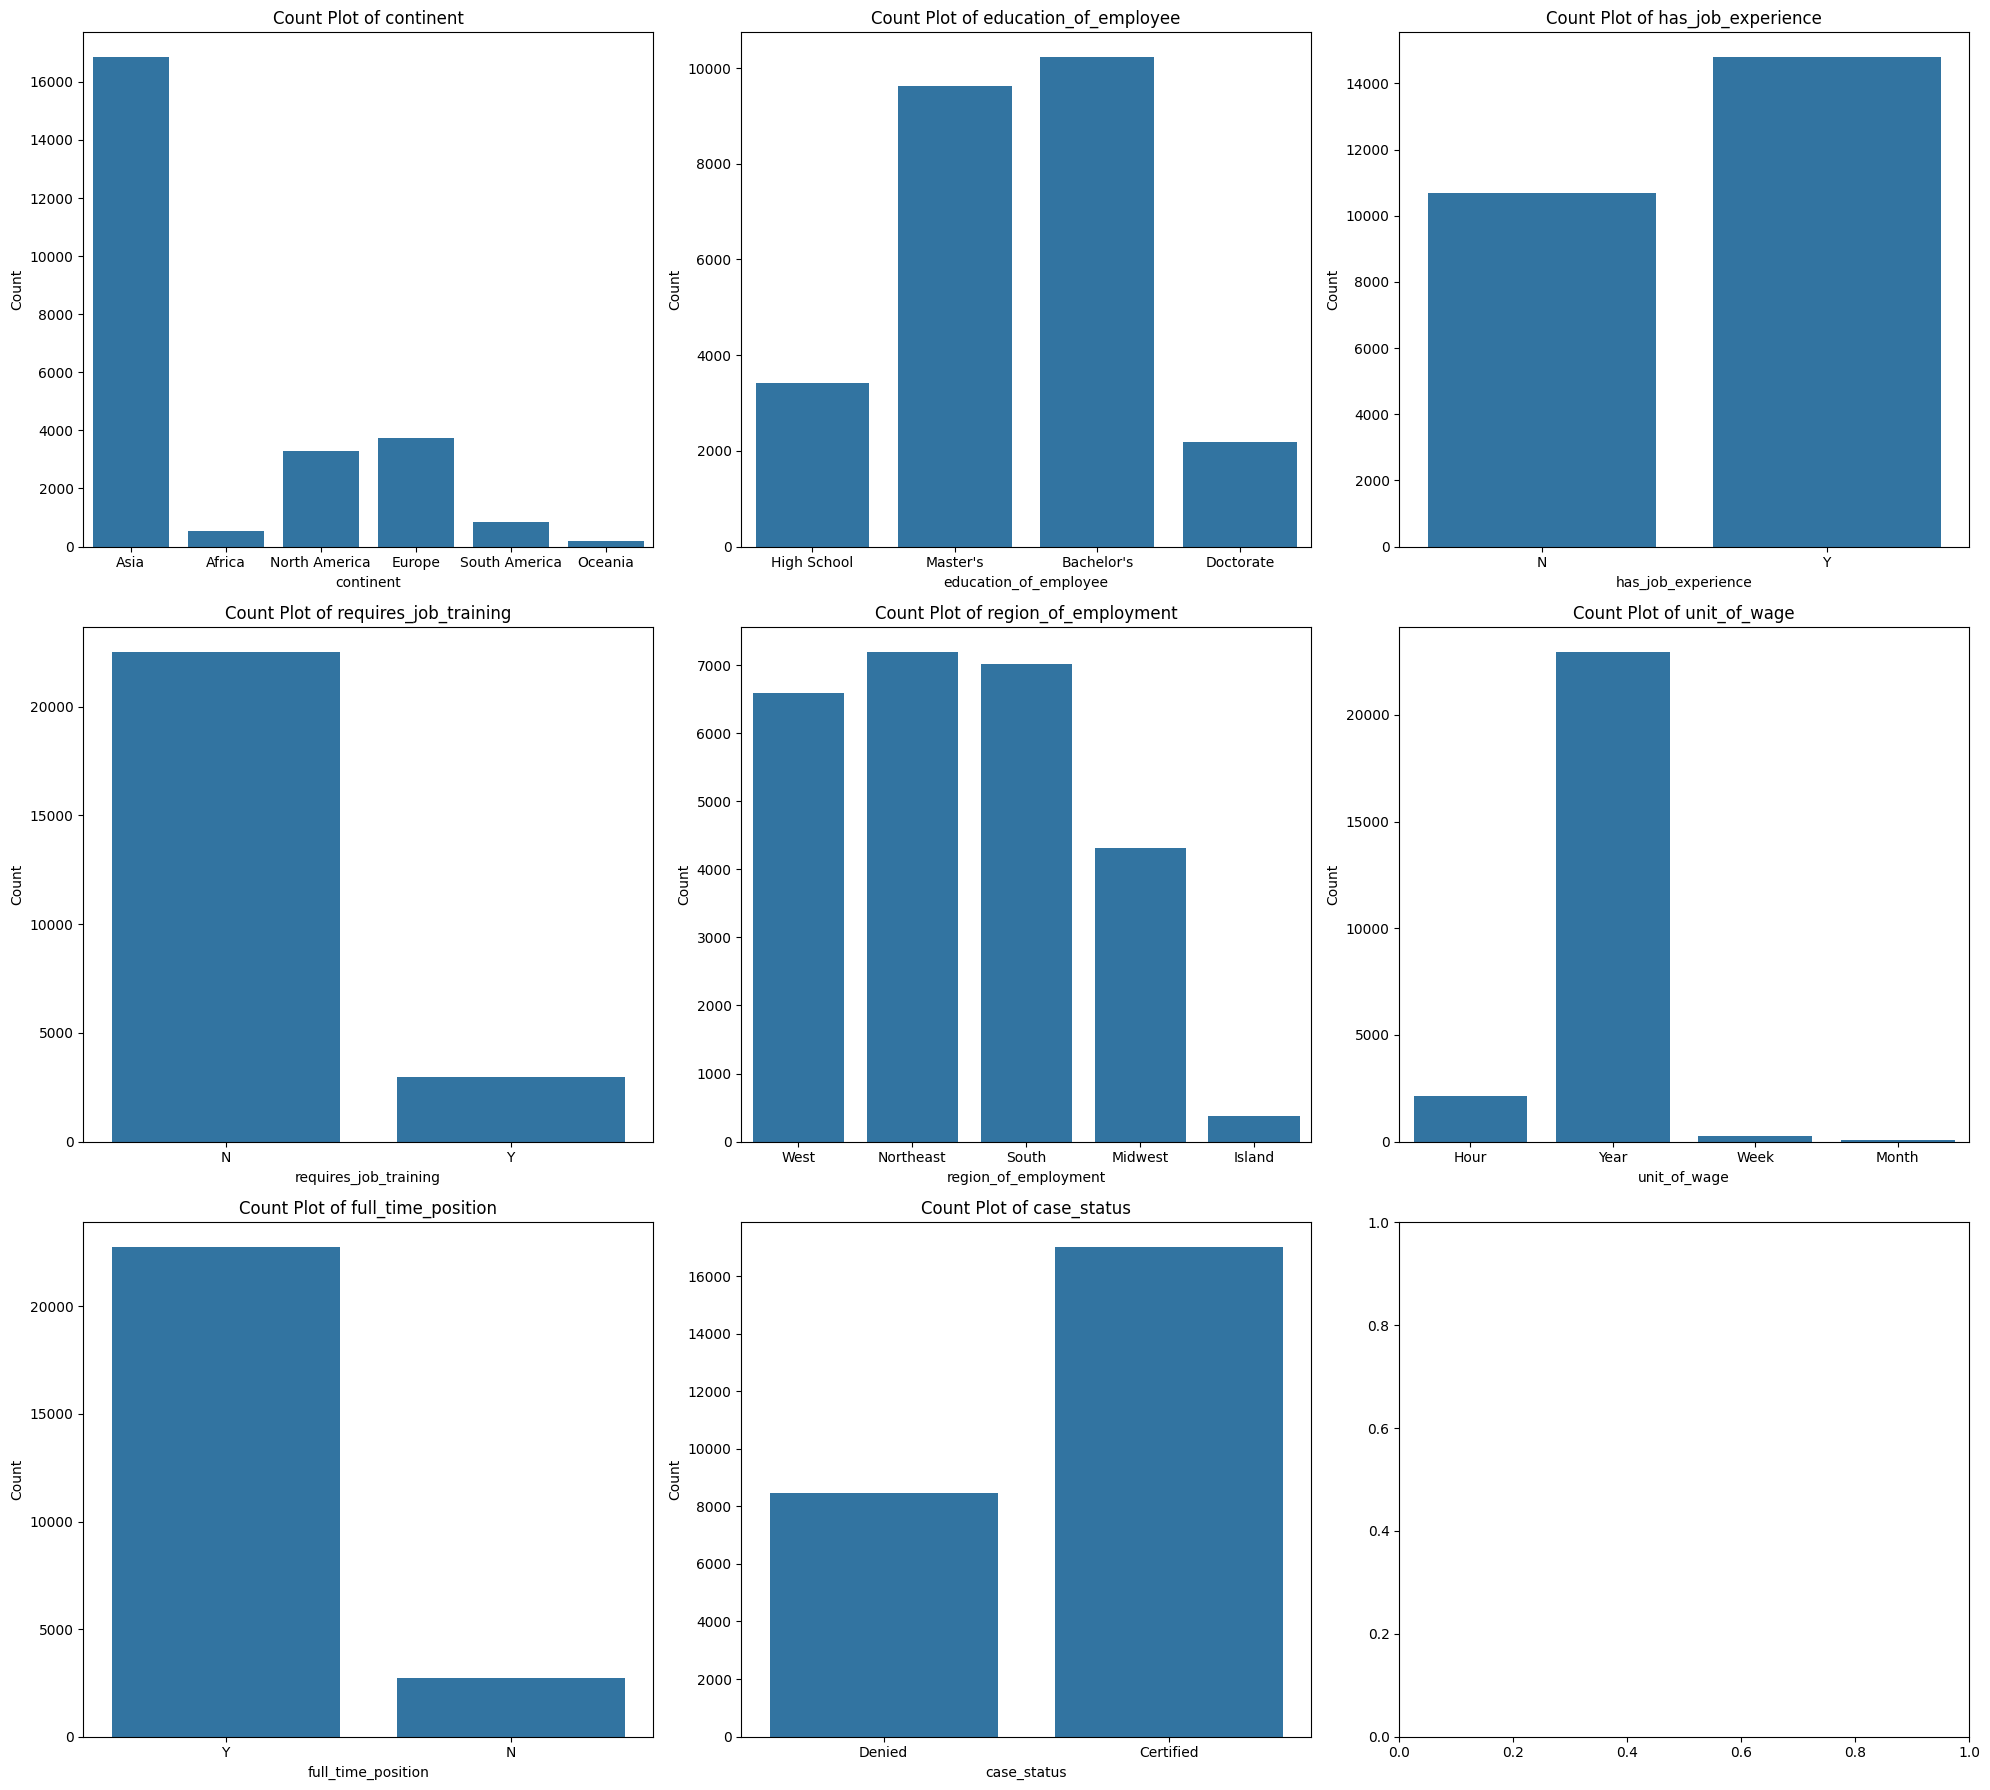

In [7]:

categorical_columns = ['continent', 'education_of_employee', 'has_job_experience', 
                      'requires_job_training', 'region_of_employment', 
                      'unit_of_wage', 'full_time_position', 'case_status']

fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.ravel()
for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(f'Count Plot of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
plt.tight_layout()

### Bivariate Analysis

#### Relationship of features with case_status

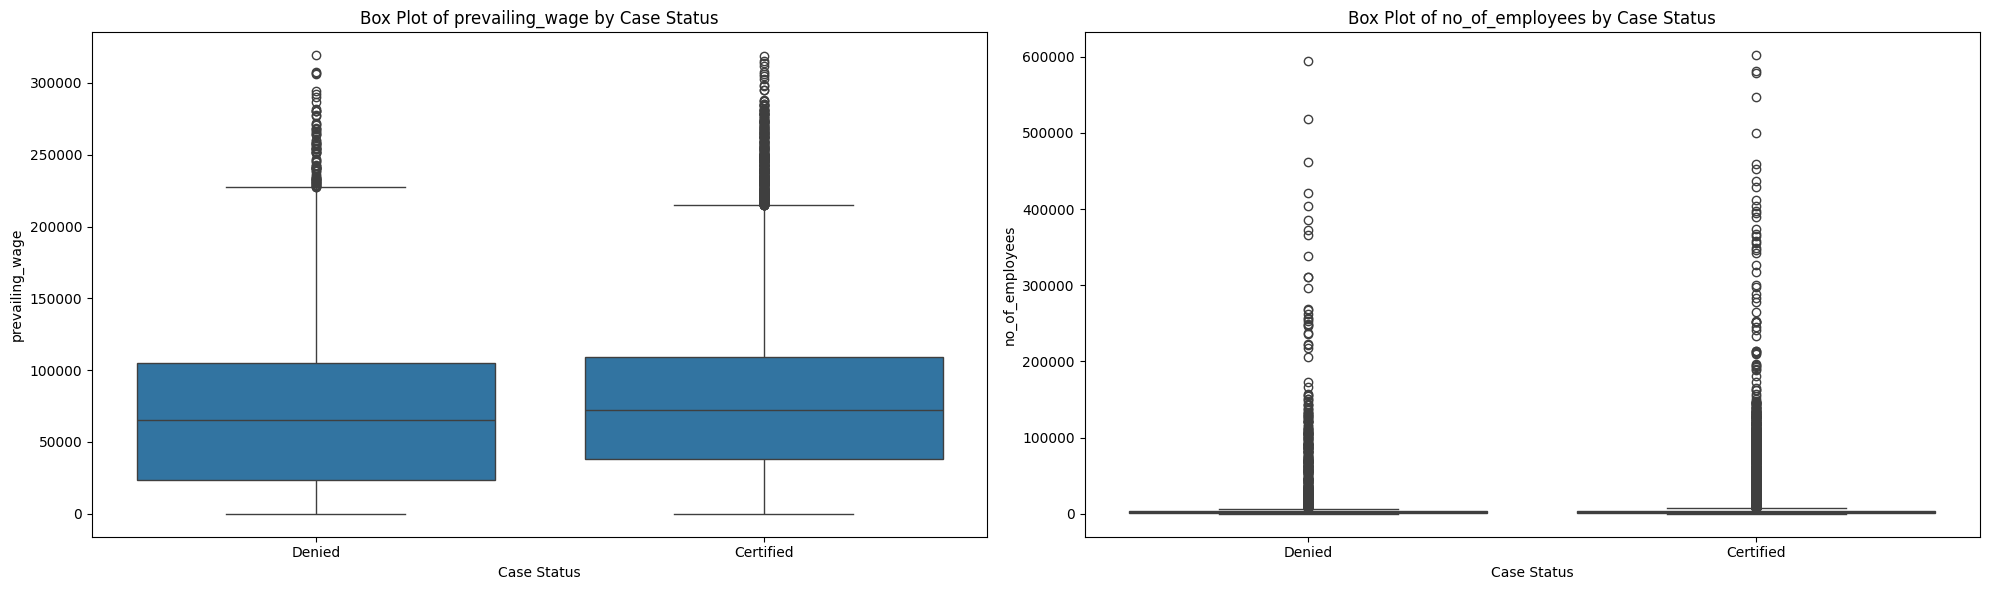

In [8]:
# Box plots
numerical_columns = ['prevailing_wage', 'no_of_employees']

fig, axes = plt.subplots(1, len(numerical_columns), figsize=(20, 6))
for i, col in enumerate(numerical_columns):
    sns.boxplot(x='case_status', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'Box Plot of {col} by Case Status')
    axes[i].set_xlabel('Case Status')
    axes[i].set_ylabel(col)
plt.tight_layout()

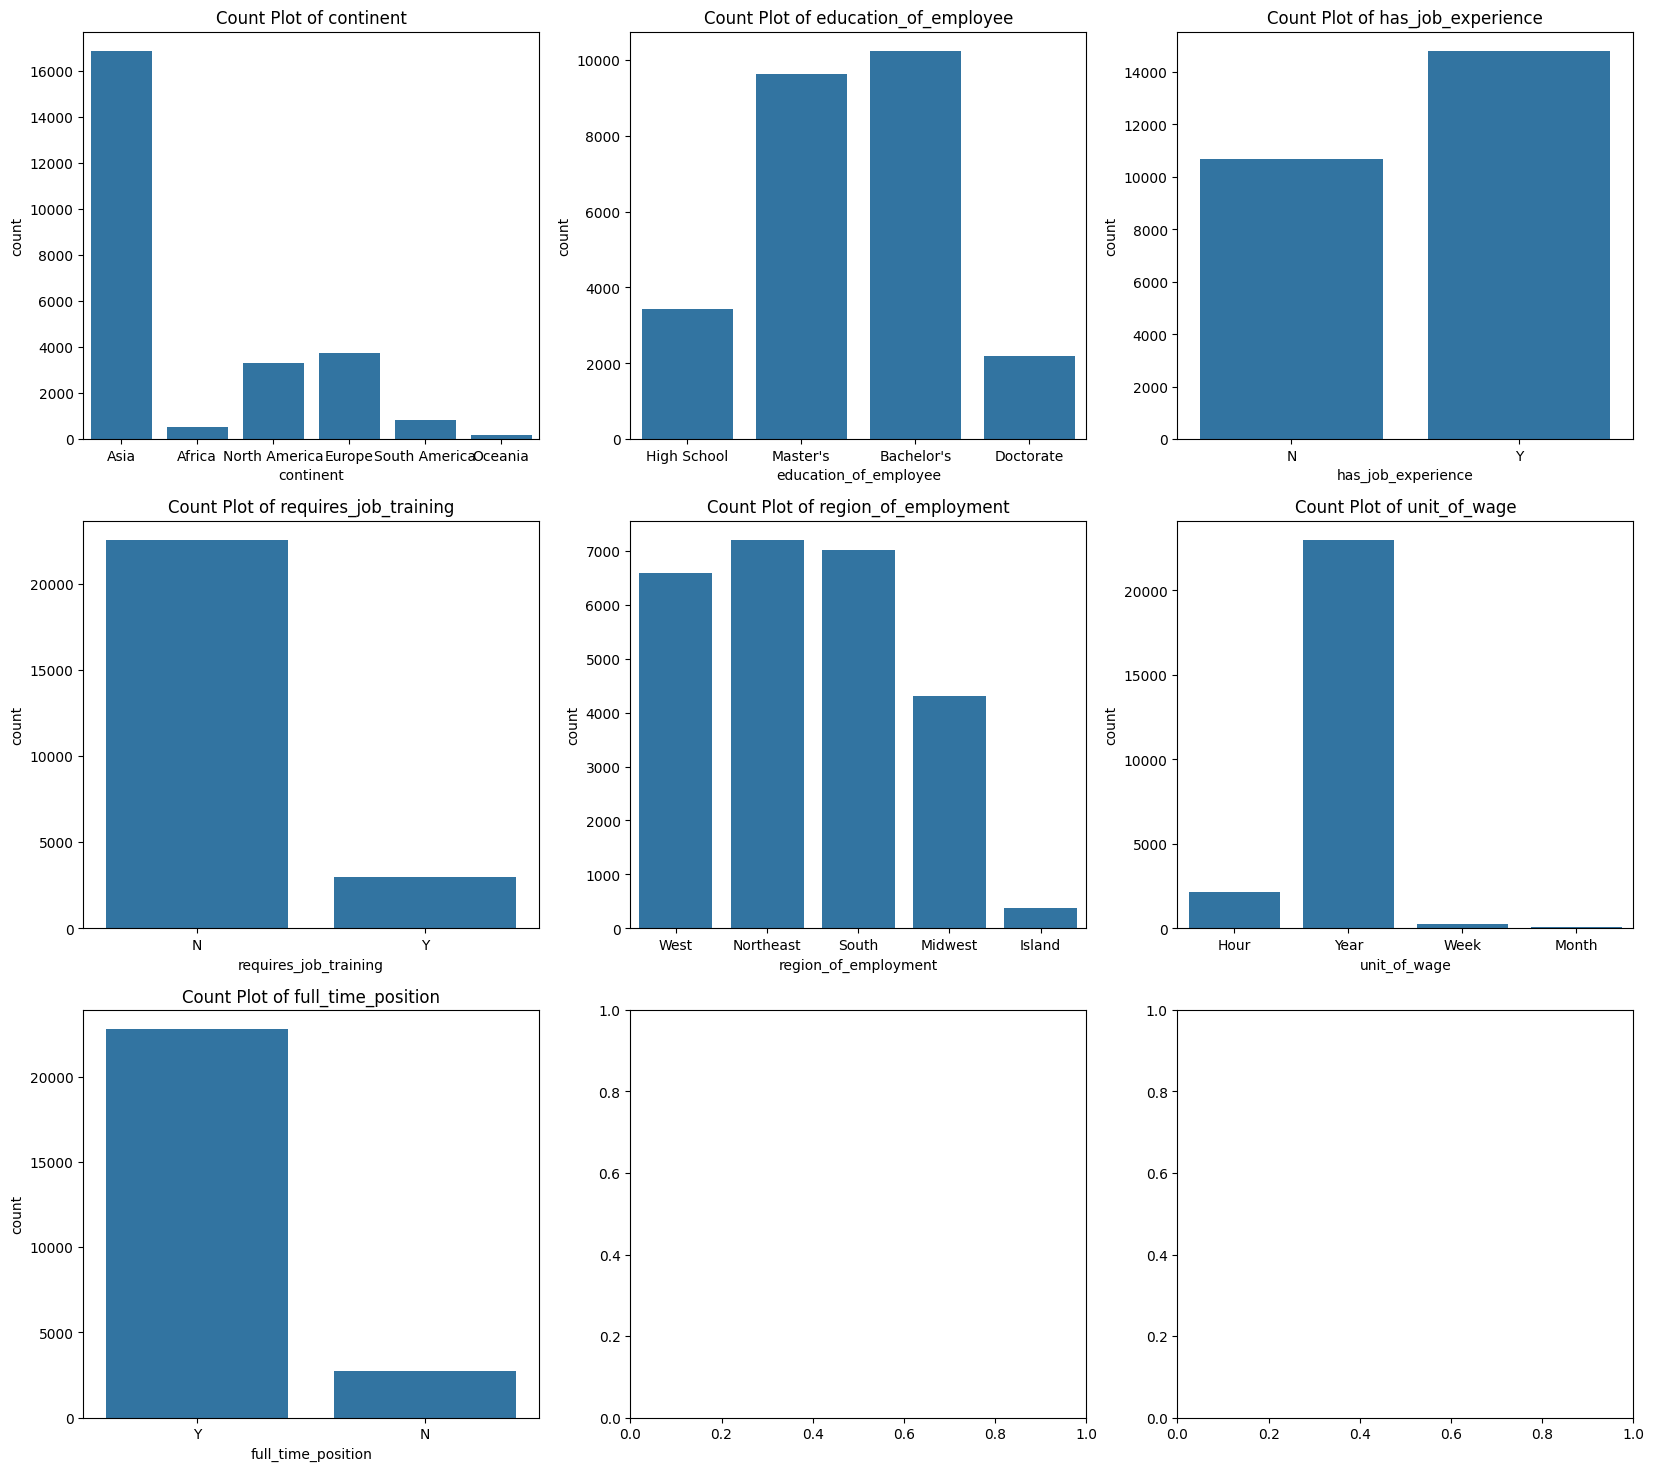

In [9]:
# Count plots
categorical_columns = ['continent', 'education_of_employee', 'has_job_experience', 
                      'requires_job_training', 'region_of_employment', 
                      'unit_of_wage', 'full_time_position']

fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.ravel()
for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(f'Count Plot of {col}')
    axes[i].set_xlabel(col)

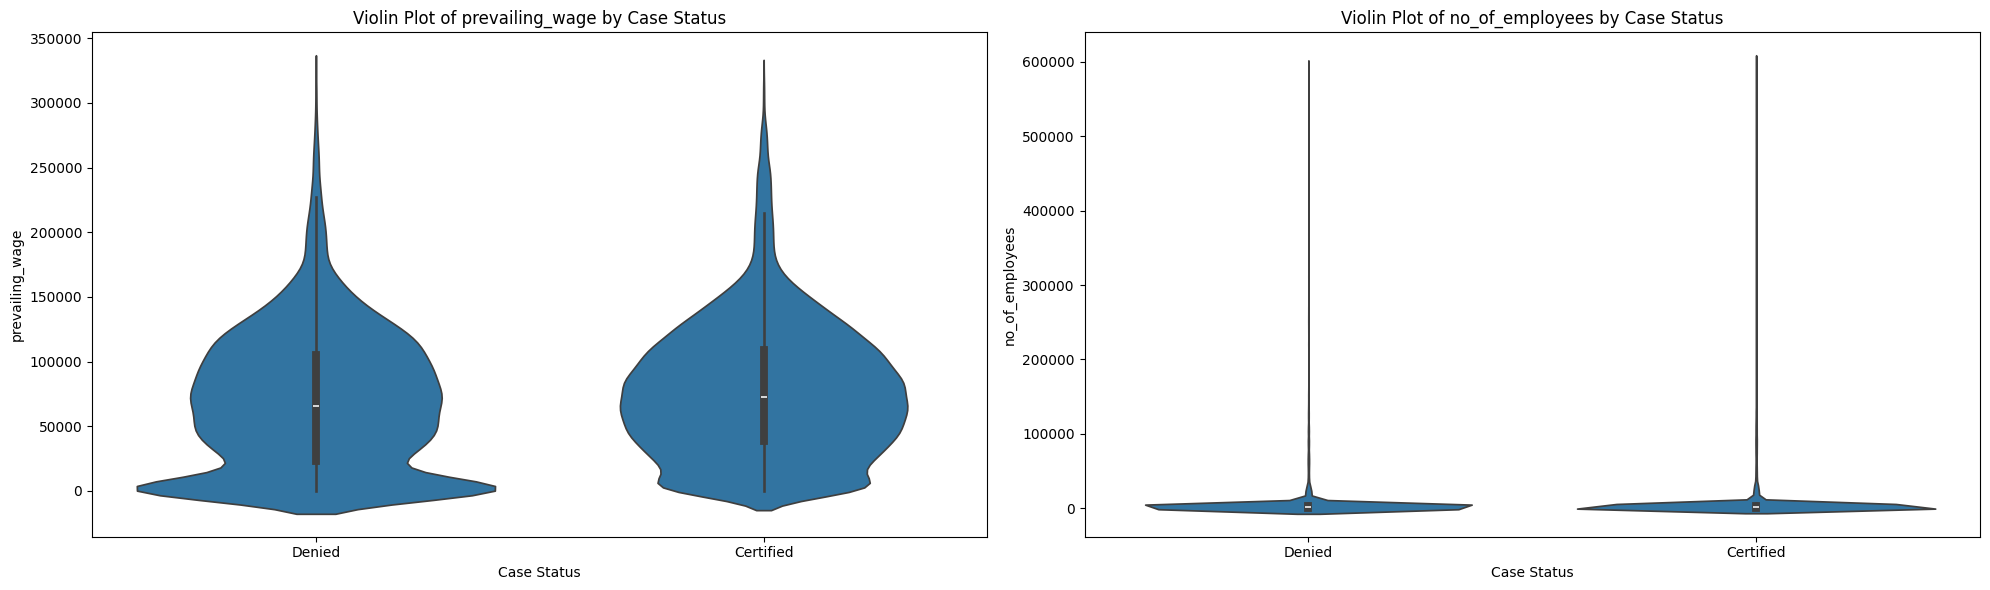

In [10]:
# Violin plots
fig, axes = plt.subplots(1, len(numerical_columns), figsize=(20, 6))
for i, col in enumerate(numerical_columns):
    sns.violinplot(x='case_status', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'Violin Plot of {col} by Case Status')
    axes[i].set_xlabel('Case Status')
    axes[i].set_ylabel(col)
plt.tight_layout()

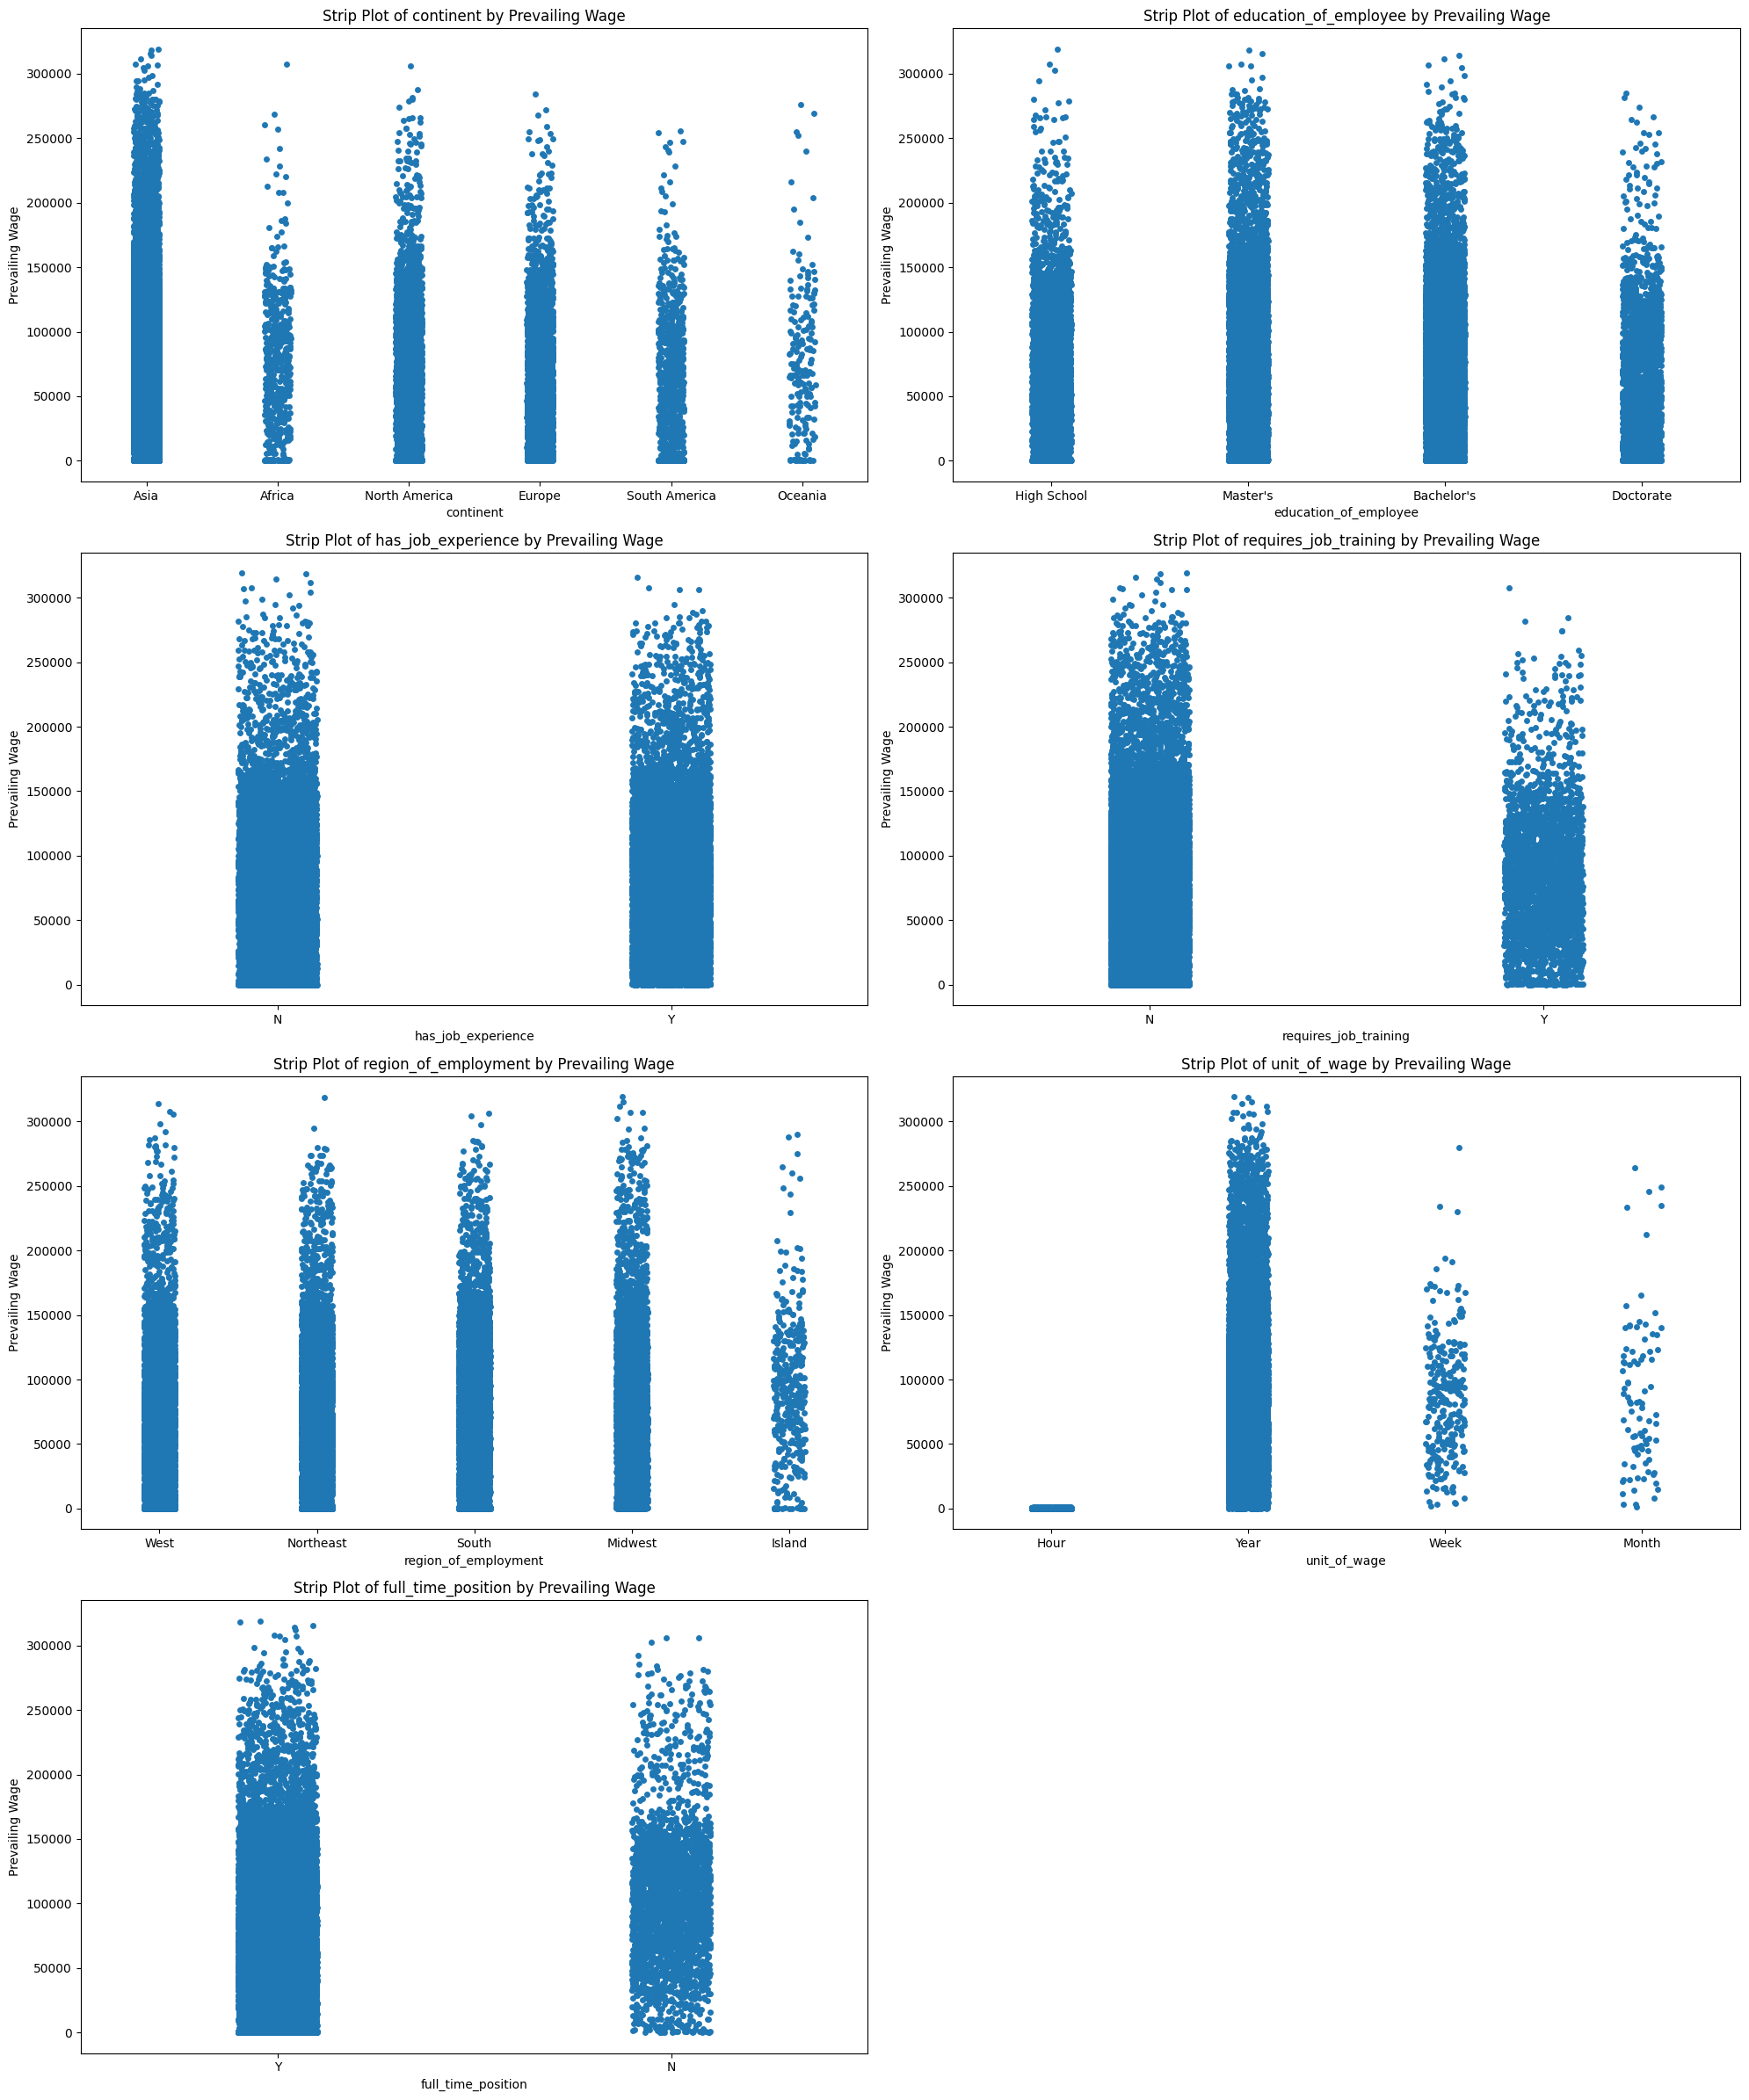

In [11]:
# Grouped bar plots or strip plots
rows = (len(categorical_columns) + 1) // 2  # Calculate number of rows needed for 2 columns
fig, axes = plt.subplots(rows, 2, figsize=(20, 6*rows))
axes = axes.ravel()  # Flatten the 2D array of axes
for i, col in enumerate(categorical_columns):
    sns.stripplot(x=col, y='prevailing_wage', data=df, ax=axes[i])
    axes[i].set_title(f'Strip Plot of {col} by Prevailing Wage')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Prevailing Wage')
# Hide any empty subplots if odd number of categories
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()

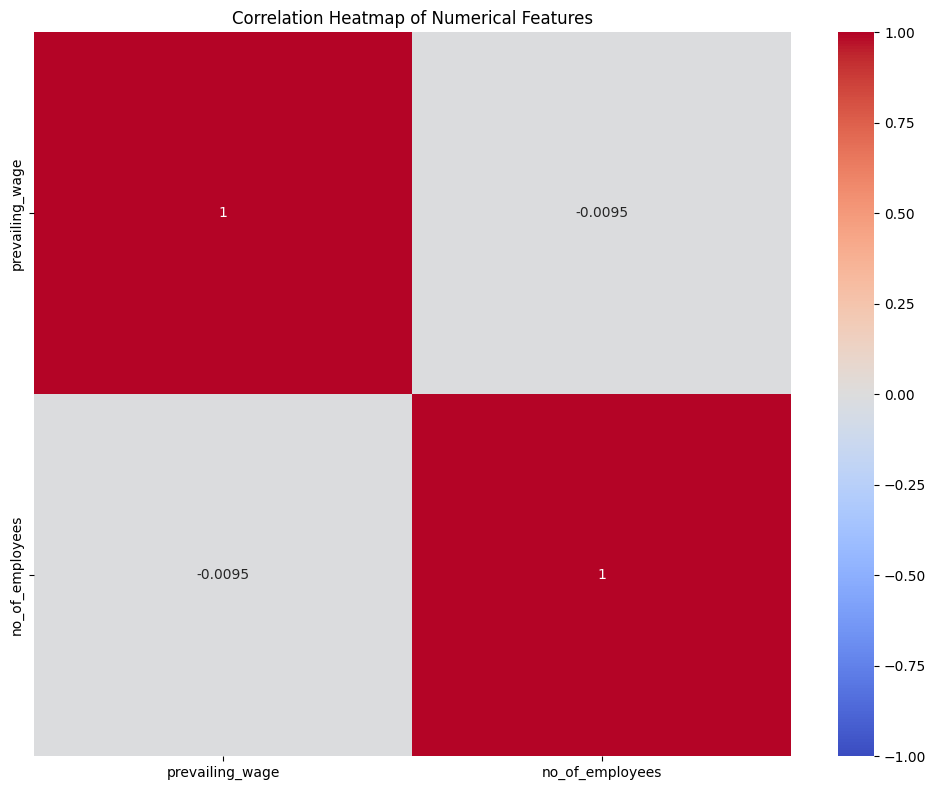

In [12]:
#Correlation heatmap (numerical features)
numerical_columns = ['prevailing_wage', 'no_of_employees']

# Calculate the correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()


### Key Insights

#### Univariate Observations

- prevailing_wage is right-skewed, with most values under $100,000.
- no_of_employees is highly skewed.
- Most applicants are from Asia.
- Most applicants have either Bachelor’s or Master’s degrees.
- A significant number of employees have job experience, and most do not require job training.
- Most jobs are full-time, and wages are mainly on a yearly basis.


####  Bivariate Insights
 - Higher prevailing wages seem to have a slight positive impact on visa approval
 - No clear correlation between number of employees and visa approval — the relationship appears flat.
 - Applications with job experience are more likely to be approved.
 - Full-time positions are overwhelmingly approved more often than part-time.

#### no correlation between numerical variables (prevailing_wage and no_of_employees),

##  Data Preprocessing

In [13]:
# Drop unnecessary columns
df = df.drop(columns=['case_id'])

In [14]:
# Handle outliers (e.g., wage outliers)
df = df[df['prevailing_wage'] < 1000000]
# Normalize/standardize wages
df['prevailing_wage_normalized'] = (df['prevailing_wage'] - df['prevailing_wage'].mean()) / df['prevailing_wage'].std()


In [15]:
# Feature engineering (e.g., company_age)
df['company_age'] = df['yr_of_estab'].apply(lambda x: 2024 - x)

In [16]:
df.describe()

,no_of_employees,yr_of_estab,prevailing_wage,prevailing_wage_normalized,company_age
count,25480.000000,25480.000000,25480.000000,2.548000e+04,25480.000000
mean,5667.043210,1979.409929,74455.814592,8.421660e-17,44.590071
std,22877.928848,42.366929,52815.942327,1.000000e+00,42.366929
min,-26.000000,1800.000000,2.136700,-1.409682e+00,8.000000
25%,1022.000000,1976.000000,34015.480000,-7.656842e-01,19.000000
50%,2109.000000,1997.000000,70308.210000,-7.852941e-02,27.000000
75%,3504.000000,2005.000000,107735.512500,6.301071e-01,48.000000
max,602069.000000,2016.000000,319210.270000,4.634102e+00,224.000000


In [17]:
# Convert to 1 and 0 for binary variables
binary_cols = ['has_job_experience', 'requires_job_training', 'full_time_position']
for col in binary_cols:
    df[col] = df[col].map({'Y': 1, 'N': 0})

binary_cols = ['case_status']
for col in binary_cols:
    df[col] = df[col].map({'Certified': 1, 'Denied': 0})

In [18]:
# one hot encoding for categorical variables
categorical_cols = ['continent', 'education_of_employee', 'region_of_employment', 'unit_of_wage']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   has_job_experience                 25480 non-null  int64  
 1   requires_job_training              25480 non-null  int64  
 2   no_of_employees                    25480 non-null  int64  
 3   yr_of_estab                        25480 non-null  int64  
 4   prevailing_wage                    25480 non-null  float64
 5   full_time_position                 25480 non-null  int64  
 6   case_status                        25480 non-null  int64  
 7   prevailing_wage_normalized         25480 non-null  float64
 8   company_age                        25480 non-null  int64  
 9   continent_Asia                     25480 non-null  bool   
 10  continent_Europe                   25480 non-null  bool   
 11  continent_North America            25480 non-null  boo

## Train-Test Split

In [20]:
# Use train_test_split from sklearn
from sklearn.model_selection import train_test_split

X = df.drop(columns=["case_status"])
y = df["case_status"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Check the shape
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Target distribution in training set:")
print(y_train.value_counts(normalize=True))

Training set shape: (20384, 23)
Test set shape: (5096, 23)
Target distribution in training set:
case_status
1    0.667877
0    0.332123
Name: proportion, dtype: float64


## Model Building – Original Data

### Train the following 5 classifiers:
 - Decision Tree
 - Random Forest
 - Bagging Classifier
 - AdaBoost
 - XGBoost
 - Evaluate using Accuracy, Precision, Recall, F1, ROC-AUC
 - Compare results in a summary table

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Bagging': BaggingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # For ROC-AUC

    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    }

results = []

for name, model in models.items():
    result = evaluate_model(name, model, X_train, X_test, y_train, y_test)
    results.append(result)

results_df = pd.DataFrame(results).sort_values(by='ROC-AUC', ascending=False)
display(results_df)

/Users/siddhartha/miniconda3/envs/gl/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:00:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
3,AdaBoost,0.731554,0.755907,0.883373,0.814684,0.755579
4,XGBoost,0.726060,0.764072,0.853408,0.806273,0.753637
1,Random Forest,0.721546,0.765872,0.839894,0.801177,0.745925
2,Bagging,0.700549,0.775852,0.775852,0.775852,0.723396
0,Decision Tree,0.654042,0.743544,0.735899,0.739702,0.612630


## Oversampled Data

### Apply SMOTE or RandomOverSampler

In [22]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print("Class distribution:", y_train_smote.value_counts())


models_smote = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Bagging': BaggingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # for ROC-AUC
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    }


results_smote = []

for name, model in models_smote.items():
    result = evaluate_model(name, model, X_train_smote, X_test, y_train_smote, y_test)
    results_smote.append(result)

results_smote_df = pd.DataFrame(results_smote).sort_values(by='ROC-AUC', ascending=False)

display(results_smote_df)

After SMOTE:
Class distribution: case_status
1    13614
0    13614
Name: count, dtype: int64


/Users/siddhartha/miniconda3/envs/gl/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:00:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
4,XGBoost,0.730965,0.770274,0.851058,0.808653,0.754615
1,Random Forest,0.716248,0.770741,0.818743,0.794017,0.742402
3,AdaBoost,0.716248,0.776398,0.807873,0.791823,0.740778
2,Bagging,0.689168,0.775424,0.752644,0.763864,0.715906
0,Decision Tree,0.657182,0.750227,0.729730,0.739836,0.620480


## Undersampled Data

### Apply RandomUnderSampler

In [23]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print("After RandomUnderSampler:")
print("Class distribution:\n", y_train_rus.value_counts())

models_rus = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Bagging': BaggingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # for ROC-AUC
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    }

results_rus = []

for name, model in models_rus.items():
    result = evaluate_model(name, model, X_train_rus, X_test, y_train_rus, y_test)
    results_rus.append(result)

results_rus_df = pd.DataFrame(results_rus).sort_values(by='ROC-AUC', ascending=False)

display(results_rus_df)

After RandomUnderSampler:
Class distribution:
 case_status
0    6770
1    6770
Name: count, dtype: int64


/Users/siddhartha/miniconda3/envs/gl/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:00:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
3,AdaBoost,0.693878,0.798962,0.723854,0.759556,0.755109
1,Random Forest,0.678964,0.811487,0.676557,0.737905,0.748431
4,XGBoost,0.678179,0.806037,0.682432,0.739103,0.744752
2,Bagging,0.644819,0.812549,0.608696,0.696003,0.720613
0,Decision Tree,0.613226,0.764684,0.608108,0.677467,0.615815


## Hyperparameter Tuning and Final Model Evaluation


In [24]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print("Best params for Random Forest:", grid_rf.best_params_)

Best params for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


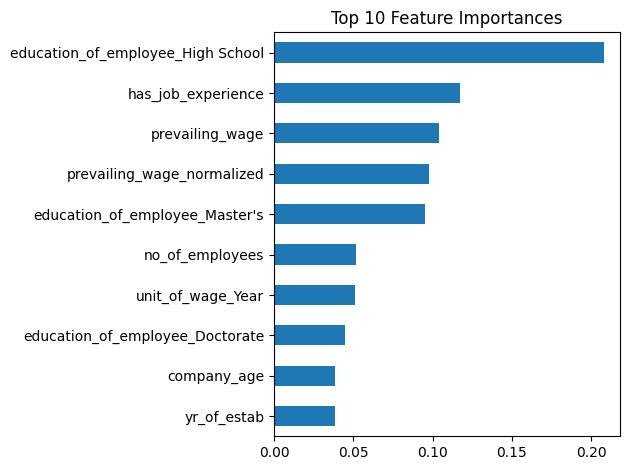

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [26]:
print("Model Performance")
display(results_df)
display(results_smote_df)
display(results_rus_df)

Model Performance


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
3,AdaBoost,0.731554,0.755907,0.883373,0.814684,0.755579
4,XGBoost,0.726060,0.764072,0.853408,0.806273,0.753637
1,Random Forest,0.721546,0.765872,0.839894,0.801177,0.745925
2,Bagging,0.700549,0.775852,0.775852,0.775852,0.723396
0,Decision Tree,0.654042,0.743544,0.735899,0.739702,0.612630


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
4,XGBoost,0.730965,0.770274,0.851058,0.808653,0.754615
1,Random Forest,0.716248,0.770741,0.818743,0.794017,0.742402
3,AdaBoost,0.716248,0.776398,0.807873,0.791823,0.740778
2,Bagging,0.689168,0.775424,0.752644,0.763864,0.715906
0,Decision Tree,0.657182,0.750227,0.729730,0.739836,0.620480


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
3,AdaBoost,0.693878,0.798962,0.723854,0.759556,0.755109
1,Random Forest,0.678964,0.811487,0.676557,0.737905,0.748431
4,XGBoost,0.678179,0.806037,0.682432,0.739103,0.744752
2,Bagging,0.644819,0.812549,0.608696,0.696003,0.720613
0,Decision Tree,0.613226,0.764684,0.608108,0.677467,0.615815


[[ 730  962]
 [ 377 3027]]
              precision    recall  f1-score   support

           0       0.66      0.43      0.52      1692
           1       0.76      0.89      0.82      3404

    accuracy                           0.74      5096
   macro avg       0.71      0.66      0.67      5096
weighted avg       0.73      0.74      0.72      5096



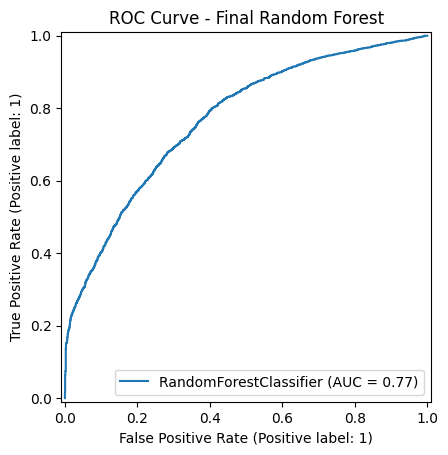

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay


y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("ROC Curve - Final Random Forest")
plt.show()

## Summary

- Model: Random Forest (tuned)
- ROC AUC: 0.77

The model does a decent job of distinguishing between approved and denied visa applications.

## Actionable Insights

- AdaBoost is best overall ROC-AUC (0.7556) and highest F1 Score (0.8147), making it the most balanced and reliable model.
- Deploy the AdaBoost classifier as part of EasyVisa’s recommendation engine for preliminary application evaluation, it will flag low-certainty applications for human review.
